In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score, median_absolute_error
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import median_absolute_error

from computage.deage.kdm import KlemeraDoubalEstimator
from computage.deage.pls import PLS1
from computage.utils.toy_data import generate_toy_data
from computage.utils.metric_utils import print_metrics
from computage.utils.nan_utils import EN_nan_row_predict, introduce_nans

# Toy data case

In [2]:
TEST_ELASTICNET = True
DATA_MODEL = 'y->x'

n = 200
p = 5000
n_signif_feat = 10 

X, y = generate_toy_data(n, p, n_signif_feat, data_model_type=DATA_MODEL)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3)

In [3]:
# def _fit_feature(y, x):
#     idx = np.isfinite(x) #y should always be finite
#     y = y[idx] 
#     x = x[idx]
#     s, i, r, p, serr = linregress(y, x)
#     x_cap = y * s + i
#     r2 = r2_score(x, x_cap)
#     rss = (np.square(x_cap - x)).sum()
#     rse = np.sqrt(rss / (x.shape[0] - 2))
#     return s, i, r, p, serr, rse, r2

# import mapply
# mapply.init(n_workers=8, chunk_size=100, max_chunks_per_worker=10, progressbar=True)
# model = X_train.mapply(lambda x: _fit_feature(y_train, x), result_type='expand').reset_index(drop=True).rename(index={0: 'slope', 
#                                                                                                 1: 'intercept', 
#                                                                                                 2: 'rvalue', 
#                                                                                                 3: 'p-value', 
#                                                                                                 4: 'stderr', 
#                                                                                                 5: 'rse',
#                                                                                                 6: 'r2'}).T

In [109]:
model = KlemeraDoubalEstimator(cv=10, 
                                cv_val_size=0.2,
                                feature_selection_method='forward',
                                feature_pval_threshold=0.05,
                                lasso_preselection=False,
                                verbose=1)
model.fit(X_train, y_train)

print()
y_pred_train = model.predict(X_train)
print('Train')
print_metrics(y_train, y_pred_train)

y_pred_test = model.predict(X_test)
print('\nTest')
print_metrics(y_test, y_pred_test)

Training estimators on full data.
4188 features remained after applying p-value threshold.
Training estimators on different cv-folds.


100%|██████████| 4188/4188 [03:21<00:00, 20.76it/s]

Remove redundant features.
66 features remained after selection.
Bvar=2.711
Finished!

Train
MAE = 1.330
R2 = 0.989
r = 0.994

Test
MAE = 1.729
R2 = 0.974
r = 0.988


In [110]:
pls = DeAge(n_components=3)
pls.fit(X_train, y_train)

y_pred_train = pls.predict(X_train)
print('Train')
print_metrics(y_train, y_pred_train)

y_pred_test = pls.predict(X_test)
print('\nTest')
print_metrics(y_test, y_pred_test)

Train
MAE = 0.010
R2 = 1.000
r = 1.000

Test
MAE = 0.479
R2 = 0.998
r = 0.999


In [111]:
if TEST_ELASTICNET:
    en = ElasticNetCV(l1_ratio=0.5)
    en.fit(X_train, y_train)
    
    print('EN results')
    y_pred_train = en.predict(X_train)
    print('Train')
    print_metrics(y_train, y_pred_train)

    y_pred_test = en.predict(X_test)
    print('\nTest')
    print_metrics(y_test, y_pred_test)

EN results
Train
MAE = 0.018
R2 = 1.000
r = 1.000

Test
MAE = 4.306
R2 = 0.843
r = 0.960


In [112]:
nan_pct = np.linspace(0, 0.9, 19)

mae_uie = []
r2_uie = []
mae_en = []
r2_en = []
mae_pls = []
r2_pls = []
for p in nan_pct:
    X_nan = introduce_nans(X_test, p)
    
    y_pred_test = model.predict(X_nan)
    y_en_pred_test = X_nan.apply(lambda x: EN_nan_row_predict(x, en), axis=1)
    y_pls_pred_test = pls.predict(X_nan)
    
    mae_uie.append(median_absolute_error(y_test, y_pred_test))
    r2_uie.append(r2_score(y_test, y_pred_test))
    mae_en.append(median_absolute_error(y_test, y_en_pred_test))
    r2_en.append(r2_score(y_test, y_en_pred_test))
    mae_pls.append(median_absolute_error(y_test, y_pls_pred_test))
    r2_pls.append(r2_score(y_test, y_pls_pred_test))

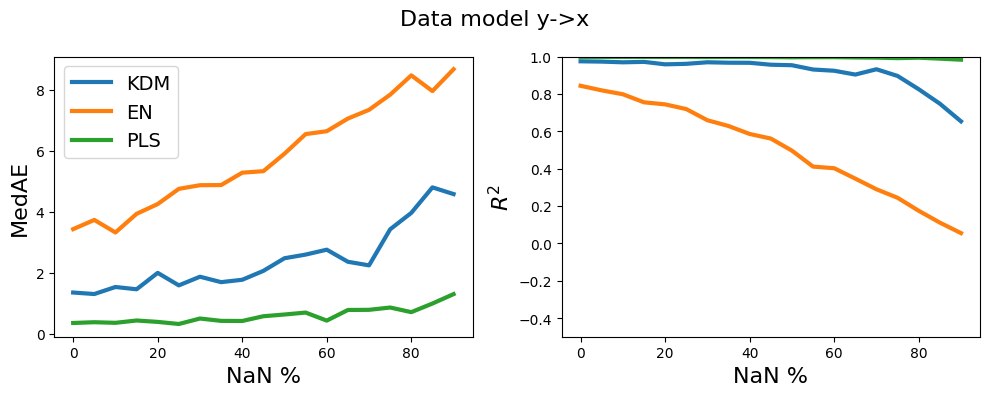

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f'Data model {DATA_MODEL}', fontsize=16)
ax[0].plot(nan_pct*100, mae_uie, lw=3, label='KDM')
ax[0].plot(nan_pct*100, mae_en, lw=3, label='EN')
ax[0].plot(nan_pct*100, mae_pls, lw=3, label='PLS')
ax[1].plot(nan_pct*100, r2_uie, lw=3)
ax[1].plot(nan_pct*100, r2_en, lw=3)
ax[1].plot(nan_pct*100, r2_pls, lw=3)
ax[0].set_xlabel('NaN %', fontsize=16)
ax[1].set_xlabel('NaN %', fontsize=16)
ax[0].set_ylabel('MedAE', fontsize=16)
ax[1].set_ylabel('$R^2$', fontsize=16)
ax[0].legend(fontsize=14)
ax[1].set_ylim([-0.5, 1.0])
plt.tight_layout()
plt.show()

# Real data case

In [7]:
import pickle
data_obj = pickle.load(open('data/GSE132040_preprocessed_RNA.pkl', 'rb'))
meta = data_obj['meta']
X = data_obj['data']
y = meta['Age']

#split to train | test
X_train, X_test, y_train, y_test, meta_train, meta_test = tts(X, y, meta, 
                                                              test_size=0.25, 
                                                              stratify=meta['Tissue'], random_state=10)

In [8]:
model = KlemeraDoubalEstimator(cv=10, 
                                cv_val_size=0.2,
                                feature_selection_method='forward',
                                feature_pval_threshold=0.05,
                                lasso_preselection=False,
                                verbose=1)
model.fit(X_train, y_train)

print()
y_pred_train = model.predict(X_train)
print('Train')
print_metrics(y_train, y_pred_train)

y_pred_test = model.predict(X_test)
print('\nTest')
print_metrics(y_test, y_pred_test)

Training estimators on full data.
4297 features remained after applying p-value threshold.
Training estimators on different cv-folds.


100%|██████████| 4297/4297 [04:08<00:00, 17.28it/s]

Remove redundant features.
38 features remained after selection.
Bvar=30.961
Finished!

Train
MAE = 4.360
R2 = 0.518
r = 0.821

Test
MAE = 4.803
R2 = 0.430
r = 0.799


In [11]:
X_train_nonan = X_train.fillna(0.)

pls = PLS1(n_components='auto')
pls.fit(X_train_nonan, y_train)

y_pred_train = pls.predict(X_train_nonan)
print('Train')
print_metrics(y_train, y_pred_train)

y_pred_test = pls.predict(X_test)
print('\nTest')
print_metrics(y_test, y_pred_test)

Start searching for the best number of PLS components.
The best number of components is 12
Train
MAE = 0.243
R2 = 0.998
r = 0.999

Test
MAE = 3.822
R2 = 0.678
r = 0.838


In [17]:
#unit test
pls_1 = PLS1(n_components=6)
pls_1.fit(X_train_nonan, y_train)

y_pred_train = pls_1.predict(X_train_nonan)
print('Train')
print_metrics(y_train, y_pred_train)

y_pred_test = pls_1.predict(X_test)
print('\nTest')
print_metrics(y_test, y_pred_test)

Train
MAE = 1.224
R2 = 0.961
r = 0.980

Test
MAE = 3.704
R2 = 0.700
r = 0.853


In [23]:
en = ElasticNet(l1_ratio=0.5, alpha=0.1)
en.fit(X_train_nonan, y_train)

print('EN results')
y_pred_train = en.predict(X_train_nonan)
print('Train')
print_metrics(y_train, y_pred_train)

y_pred_test = en.predict(X_test.fillna(0.))
print('\nTest')
print_metrics(y_test, y_pred_test)

EN results
Train
MAE = 0.526
R2 = 0.993
r = 0.997

Test
MAE = 2.968
R2 = 0.793
r = 0.895


In [24]:
nan_pct = np.linspace(0, 0.9, 19)

mae_uie = []
r2_uie = []
mae_en = []
r2_en = []
mae_pls = []
r2_pls = []
for p in nan_pct:
    X_nan = introduce_nans(X_test, p)
    
    y_pred_test = model.predict(X_nan)
    y_en_pred_test = X_nan.apply(lambda x: EN_nan_row_predict(x, en), axis=1)
    y_pls_pred_test = pls.predict(X_nan)
    
    mae_uie.append(median_absolute_error(y_test, y_pred_test))
    r2_uie.append(r2_score(y_test, y_pred_test))
    mae_en.append(median_absolute_error(y_test, y_en_pred_test))
    r2_en.append(r2_score(y_test, y_en_pred_test))
    mae_pls.append(median_absolute_error(y_test, y_pls_pred_test))
    r2_pls.append(r2_score(y_test, y_pls_pred_test))

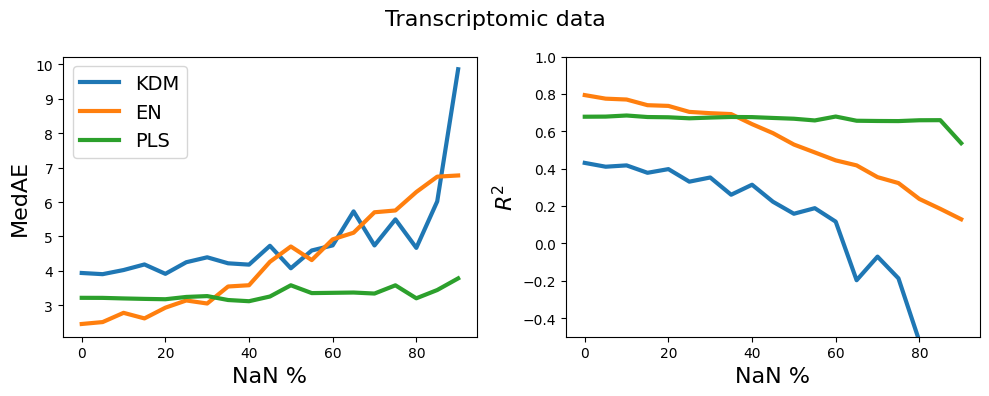

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f'Transcriptomic data', fontsize=16)
ax[0].plot(nan_pct*100, mae_uie, lw=3, label='KDM')
ax[0].plot(nan_pct*100, mae_en, lw=3, label='EN')
ax[0].plot(nan_pct*100, mae_pls, lw=3, label='PLS')
ax[1].plot(nan_pct*100, r2_uie, lw=3)
ax[1].plot(nan_pct*100, r2_en, lw=3)
ax[1].plot(nan_pct*100, r2_pls, lw=3)
ax[0].set_xlabel('NaN %', fontsize=16)
ax[1].set_xlabel('NaN %', fontsize=16)
ax[0].set_ylabel('MedAE', fontsize=16)
ax[1].set_ylabel('$R^2$', fontsize=16)
ax[0].legend(fontsize=14)
ax[1].set_ylim([-0.5, 1.0])
plt.tight_layout()
plt.show()